In [1]:
# SPA vs COIN_FF vs COIN_FF_RL (imitation of COIN_FF)

import math
import random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Set
from collections import defaultdict
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString
import networkx as nx
import heapq

## 1. Load shapefile and build TrafficNetwork

In [2]:
# Path to your shapefile
path = "./trimmed_manhattan_shape/trimmed_manhattan.shp"
gdf = gpd.read_file(path)
print("CRS:", gdf.crs)
print("Geometry types:", gdf.geom_type.unique())
print("Columns:", gdf.columns.tolist())

# If CRS is geographic (lat/lon), reproject to EPSG:2263 (NY State Plane)
if gdf.crs is not None and gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=2263)
print("Reprojected CRS: ", gdf.crs)

CRS: EPSG:4326
Geometry types: ['LineString']
Columns: ['osm_id', 'name', 'highway', 'oneway', 'geometry']
Reprojected CRS:  EPSG:2263


## 2. Core types

In [3]:
Node = Tuple[float, float]     # (x, y)
EdgeId = Tuple[Node, Node]     # directed edge
EdgeFlows = Dict[EdgeId, float]


@dataclass
class Edge:
    start: Node
    end: Node
    length_m: float       # meters
    v_free: float         # free-flow speed (m/s)
    capacity: float       # max cars that fit on this segment
    alpha: float = 0.15   # BPR parameters
    beta: float = 4.0

    @property
    def free_time(self) -> float:
        """Free-flow travel time (seconds)."""
        return self.length_m / self.v_free

    def travel_time(self, flow: float) -> float:
        """BPR-style congestion travel time (seconds)."""
        x = flow / self.capacity if self.capacity > 0 else 0.0
        return self.free_time * (1.0 + self.alpha * (x ** self.beta))


Graph = Dict[Node, List[EdgeId]]


@dataclass
class TrafficNetwork:
    graph: Graph
    edges: Dict[EdgeId, Edge]


def make_node(x: float, y: float, ndigits: int = 3) -> Node:
    """Rounding keeps nodes consistent instead of tiny float differences."""
    return round(x, ndigits), round(y, ndigits)


## 3. Stochastic edge parameters

## Constants

In [4]:
# --- Capacity tuning constants (put near top of file) ---
# Default lanes by OSM 'highway' tag (very rough)
HIGHWAY_DEFAULT_LANES = {
    "motorway": 6,
    "trunk": 5,
    "primary": 5,
    "secondary": 4,
    "tertiary": 2,
    "residential": 2,
    "service": 2,
}

REF_SPEED = 13.89           # m/s ≈ 50 km/h
SPEED_CAPACITY_GAMMA = 0.2  # how strongly speed affects capacity

# Put these near the top of the file, next to your other globals
CAPACITY_SCALE = 20.0    # global multiplier for capacities
MIN_CAPACITY   = 500.0   # minimum cars per directed edge (model units)



In [5]:
def sample_car_length() -> float:
    # lognormal with median around 4.5m
    mu = math.log(4.5)
    sigma = 0.15
    length = random.lognormvariate(mu, sigma)
    return max(length, 3.5)  # clamp to > 3.5m


def sample_gap() -> float:
    # lognormal with median around 1.5m
    mu = math.log(1.5)
    sigma = 0.25
    gap = random.lognormvariate(mu, sigma)
    return max(gap, 0.5)


def sample_spacing() -> float:
    """Space per vehicle = car length + gap."""
    return sample_car_length() + sample_gap()


def sample_free_speed_time_based() -> float:
    """
    Sample free-flow speed via a lognormal model on time-per-meter.
    This gives a fatter tail toward low speeds.
    """
    median_s_per_m = 0.09  # ~40 km/h
    mu = math.log(median_s_per_m)
    sigma = 0.3  # spread; larger => more slow edges
    s_per_m = random.lognormvariate(mu, sigma)  # seconds per meter
    v_free = 1.0 / s_per_m  # m/s

    # clamp speeds to a plausible urban range ~ 18–90 km/h
    v_free = max(min(v_free, 25.0), 5.0)
    return v_free

def network_from_streets_gdf(streets_gdf: gpd.GeoDataFrame) -> TrafficNetwork:
    """
    Build a directed TrafficNetwork from a GeoDataFrame of street segments.

    Capacity is based on:
        - geometric length / spacing  (cars that fit on the segment)
        - free-flow speed (faster links get slightly higher capacity)
        - a global CAPACITY_SCALE (so capacities are large vs. agent flows)
        - a global MIN_CAPACITY (so no edge is absurdly small)

    The result is that, for your Manhattan test with ~100 agents,
    typical v/c ratios stay in a reasonable range instead of exploding.
    """
    graph: Dict[Node, List[EdgeId]] = defaultdict(list)
    edges: Dict[EdgeId, Edge] = {}

    for _, row in streets_gdf.iterrows():
        geom = row.geometry
        if geom is None:
            continue

        # Handle MultiLineString and LineString
        if isinstance(geom, MultiLineString):
            line_geoms = list(geom.geoms)
        elif isinstance(geom, LineString):
            line_geoms = [geom]
        else:
            continue

        for line in line_geoms:
            coords = list(line.coords)
            if len(coords) < 2:
                continue

            for (x1, y1), (x2, y2) in zip(coords[:-1], coords[1:]):
                u = make_node(x1, y1)
                v = make_node(x2, y2)

                seg = LineString([(x1, y1), (x2, y2)])
                length_m = seg.length

                # --- stochastic spacing & free-flow speed ---
                spacing = sample_spacing()                # [m / car]
                v_free  = sample_free_speed_time_based()  # [m / s]

                # cars that physically fit on this small segment
                base_cars = max(length_m / spacing, 1.0)

                # modest boost for faster links (e.g. avenues vs local streets)
                v_ref = 15.0  # m/s ≈ 54 km/h
                speed_factor = max(v_free / v_ref, 0.5)   # avoid tiny factors

                # final capacity for this directed edge
                capacity = base_cars * speed_factor * CAPACITY_SCALE
                capacity = max(capacity, MIN_CAPACITY)

                # directed u -> v
                e1 = (u, v)
                if e1 not in edges:
                    edges[e1] = Edge(
                        start=u,
                        end=v,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[u].append(e1)

                # bidirectional by default
                e2 = (v, u)
                if e2 not in edges:
                    edges[e2] = Edge(
                        start=v,
                        end=u,
                        length_m=length_m,
                        v_free=v_free,
                        capacity=capacity,
                    )
                    graph[v].append(e2)

    return TrafficNetwork(graph=dict(graph), edges=edges)


# Build network
manhattan_network = network_from_streets_gdf(gdf)
print(f"# nodes: {len(manhattan_network.graph)}")
print(f"# edges: {len(manhattan_network.edges)}")


# nodes: 37086
# edges: 81228


## 4. NetworkX conversion (for sanity plot)

# NX nodes: 37086 # NX edges: 81228


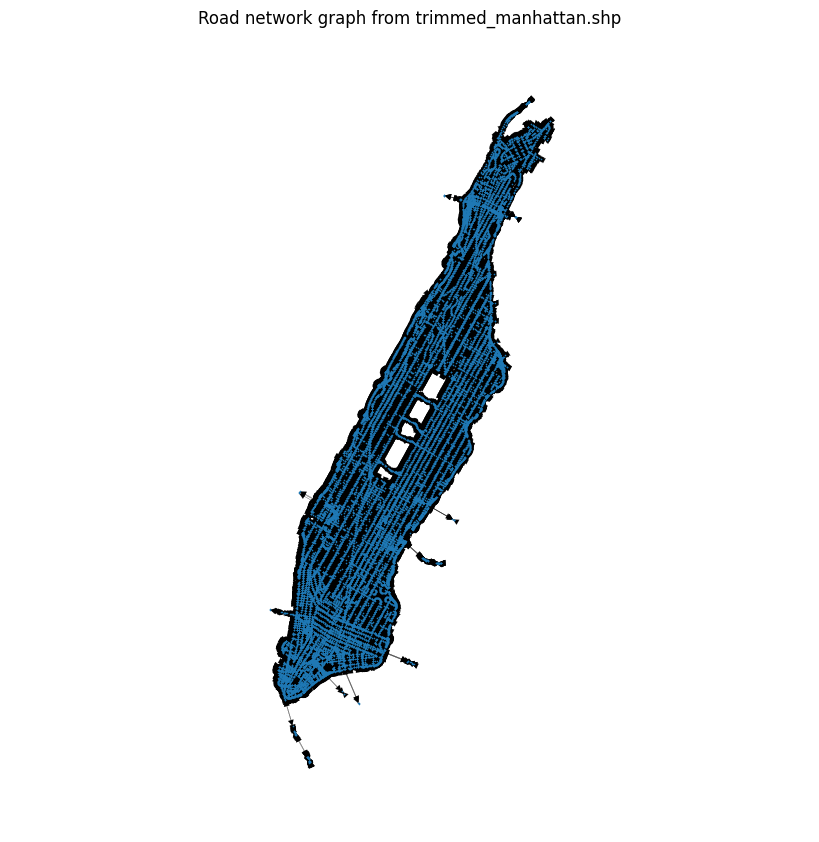

In [6]:
def to_networkx(network: TrafficNetwork) -> nx.DiGraph:
    G = nx.DiGraph()
    for node in network.graph.keys():
        G.add_node(node, x=node[0], y=node[1])
    for e_id, edge in network.edges.items():
        G.add_edge(edge.start, edge.end,
                   free_time=edge.free_time,
                   capacity=edge.capacity)
    return G


G_nx = to_networkx(manhattan_network)
print("# NX nodes:", G_nx.number_of_nodes(), "# NX edges:", G_nx.number_of_edges())

pos = {n: (n[0], n[1]) for n in G_nx.nodes()}
plt.figure(figsize=(8, 8))
nx.draw(G_nx, pos=pos, node_size=1, linewidths=0.1, width=0.1)
plt.axis("equal")
plt.title("Road network graph from trimmed_manhattan.shp")
plt.show()

## 5. Agents + OD selection

In [7]:
@dataclass
class Agent:
    origin: Node
    destination: Node
    path: List[Node] = None


def sample_agents_random(network: TrafficNetwork, num_agents: int) -> List[Agent]:
    nodes = list(network.graph.keys())
    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(nodes)
        d = random.choice(nodes)
        while d == o:
            d = random.choice(nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def sample_agents_north_south(
    network: TrafficNetwork,
    num_agents: int,
    band_split: float = 0.5,
) -> List[Agent]:
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)
    y_mid = y_min + band_split * (y_max - y_min)

    north_nodes = [n for n in nodes if n[1] >= y_mid]
    south_nodes = [n for n in nodes if n[1] <= y_mid]
    assert north_nodes and south_nodes, "North/south bands empty – check CRS/band_split."

    agents: List[Agent] = []
    for _ in range(num_agents):
        o = random.choice(north_nodes)
        d = random.choice(south_nodes)
        agents.append(Agent(origin=o, destination=d))
    return agents


def pick_north_south_pair(network: TrafficNetwork) -> Tuple[Node, Node]:
    """Pick a single north–south OD pair to keep SPA / COIN_FF comparable."""
    nodes = list(network.graph.keys())
    ys = [y for (_, y) in nodes]
    y_min, y_max = min(ys), max(ys)

    # north = top 20%, south = bottom 20%
    north_nodes = [n for n in nodes if n[1] >= y_min + 0.8 * (y_max - y_min)]
    south_nodes = [n for n in nodes if n[1] <= y_min + 0.2 * (y_max - y_min)]

    o = random.choice(north_nodes)
    d = random.choice(south_nodes)
    return o, d


def sample_agents_fixed(
    network: TrafficNetwork,
    num_agents: int,
    origin: Node,
    destination: Node
) -> List[Agent]:
    return [Agent(origin=origin, destination=destination) for _ in range(num_agents)]


## 6. Dijkstra (SPA) and marginal-cost Dijkstra (COIN_FF)

In [8]:
def dijkstra(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """Standard Dijkstra where cost = current travel time t(flow)."""
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        d_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end
            w = edge.travel_time(edge_flows[edge_id])
            nd = d_u + w
            if v not in dist or nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(pq, (nd, v))

    if target not in dist:
        return []  # no path found

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edge_marginal_cost(edge: Edge, flow_before: float) -> float:
    """
    Given that 'flow_before' cars already use this edge,
    what is the marginal increase in total system travel time G
    if we send one more car along it?
    """
    f1 = flow_before
    f2 = flow_before + 1
    t1 = edge.travel_time(f1)
    t2 = edge.travel_time(f2)
    G1 = f1 * t1
    G2 = f2 * t2
    return G2 - G1


def dijkstra_coin_ff_marginal(
    network: TrafficNetwork,
    source: Node,
    target: Node,
    edge_flows: EdgeFlows
) -> List[Node]:
    """
    Ford–Fulkerson style path search:
    shortest path where edge weight is the *marginal increase in G*
    if we send one additional car along that edge.
    Edges with flow >= capacity are treated as 'blocked'.
    """
    graph, edges = network.graph, network.edges

    dist: Dict[Node, float] = {source: 0.0}
    prev: Dict[Node, Node] = {}
    pq = [(0.0, source)]
    visited = set()

    while pq:
        cost_u, u = heapq.heappop(pq)
        if u in visited:
            continue
        visited.add(u)
        if u == target:
            break

        for edge_id in graph.get(u, []):
            edge = edges[edge_id]
            v = edge.end

            # Respect capacity (no residual capacity => no edge)
            if edge_flows[edge_id] >= edge.capacity:
                continue

            f_before = edge_flows[edge_id]
            marginal = edge_marginal_cost(edge, f_before)
            new_cost = cost_u + marginal

            if v not in dist or new_cost < dist[v]:
                dist[v] = new_cost
                prev[v] = u
                heapq.heappush(pq, (new_cost, v))

    if target not in dist:
        return []  # no path

    # Reconstruct path
    path: List[Node] = []
    cur = target
    while cur != source:
        path.append(cur)
        cur = prev[cur]
    path.append(source)
    path.reverse()
    return path


def edges_from_path(path: List[Node]) -> List[EdgeId]:
    return list(zip(path[:-1], path[1:]))



## 7. Routing: SPA and COIN_FF

In [9]:
def spa_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """Selfish Path Assignment (SPA): each agent uses shortest travel-time path."""
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra(network, agent.origin, agent.destination, edge_flows)
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0  # 1 vehicle per agent
    return agents, edge_flows


def ford_fulkerson_route_all(network: TrafficNetwork, agents: List[Agent]) -> Tuple[List[Agent], EdgeFlows]:
    """
    Ford–Fulkerson–style COIN:
    - For each agent, find a path that minimizes the marginal increase in G
      (using dijkstra_coin_ff_marginal).
    - Push 1 unit of flow along that path.
    """
    edge_flows: EdgeFlows = defaultdict(float)
    for agent in agents:
        path = dijkstra_coin_ff_marginal(
            network,
            agent.origin,
            agent.destination,
            edge_flows
        )
        agent.path = path
        for e in edges_from_path(path):
            edge_flows[e] += 1.0
    return agents, edge_flows


## 8. World utility & OD used for fixed experiments

In [10]:
def total_system_travel_time(network: TrafficNetwork, edge_flows: EdgeFlows) -> float:
    total = 0.0
    for e_id, flow in edge_flows.items():
        edge = network.edges[e_id]
        total += flow * edge.travel_time(flow)
    return total


# Fixed OD pair (global, to keep things simple and consistent)
origin, destination = pick_north_south_pair(manhattan_network)
zero_flows = defaultdict(float)
shortest_path = dijkstra(manhattan_network, origin, destination, zero_flows)
shortest_edges = set(edges_from_path(shortest_path))

print("Origin:", origin)
print("Destination:", destination)
print("Shortest path length (edges):", len(shortest_path))


def dist_to_dest(node: Node, dest: Node) -> float:
    return math.dist(node, dest)

Origin: (999961.316, 248838.245)
Destination: (986987.682, 199180.339)
Shortest path length (edges): 904


## 9. Expert Learning And online Q

### Expert dataset

In [15]:
def build_ff_expert_dataset(
    network: TrafficNetwork,
    num_agents: int = 200,
    od_mode: str = "fixed"
):
    """
    Run Ford–Fulkerson-based assignment once and record expert transitions.

    Returns
    -------
    expert_steps : list of (s, d, a, edge_id)
        s : state node
        d : destination node
        a : action (next node)
        edge_id : (s, a) so we can read flow/cost later
    agents_ff : list[Agent]
    flows_ff  : EdgeFlows
    G_ff      : total system travel time under FF assignment
    """
    # --- sample agents according to od_mode ----
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    # --- route using Ford–Fulkerson expert ---
    # assume signature: ford_fulkerson_route_all(network, agents)
    agents_ff, flows_ff = ford_fulkerson_route_all(network, agents)

    expert_steps = []  # list of (s, d, a, edge_id)
    for agent in agents_ff:
        # keep only successful trajectories
        if not agent.path or agent.path[-1] != agent.destination:
            continue
        d = agent.destination
        for (s, a) in edges_from_path(agent.path):
            edge_id = (s, a)
            expert_steps.append((s, d, a, edge_id))

    print(
        f"Collected {len(expert_steps)} FF-expert (s,d,a,edge_id) steps "
        f"from {len(agents_ff)} agents."
    )
    return expert_steps, agents_ff, flows_ff

### Helpers

In [19]:
def get_neighbors(network: TrafficNetwork, node: Node) -> List[Node]:
    return [network.edges[e_id].end for e_id in network.graph.get(node, [])]


def edge_congestion_bin(edge: "Edge", flow: float) -> int:
    """
    Discretize congestion into 3 bins for COIN-style state:
      0 = low congestion
      1 = medium congestion
      2 = high congestion

    Uses the edge's capacity as reference.
    """
    cap = max(edge.capacity, 1e-6)   # avoid division by 0
    ratio = flow / cap

    if ratio < 0.3:
        return 0         # low congestion
    elif ratio < 0.7:
        return 1         # medium congestion
    else:
        return 2         # high congestion

def dist_to_dest(node: Node, dest: Node) -> float:
    """Euclidean distance (in coordinate units) from node to dest."""
    x1, y1 = node
    x2, y2 = dest
    return math.hypot(x2 - x1, y2 - y1)

## Q learning from expert (COIN)

In [39]:
# --- global RL constants (keep near the top of your RL section) ---
TIME_SCALE      = 1000.0   # scales travel times down
TERMINAL_BONUS  = 5.0      # extra reward for landing exactly on the destination
T_CAP           = 3600.0   # cap edge travel time in seconds when used in reward

# ===== RL / reward-shaping constants =====
TIME_SCALE = 1000.0    # scale travel times in reward
LAMBDA_COST = 1.0      # weight on (negative) congested travel time
LAMBDA_PROG = 0.05     # weight on progress towards destination
LAMBDA_TERM = 5.0      # terminal bonus for reaching destination
LAMBDA_EXP  = 0.05

def q_learning_train_coin_ff_from_ff_expert(
    network: TrafficNetwork,
    expert_steps,
    flows_expert: EdgeFlows,
    expert_edge_ids: Set[EdgeId],      # NEW
    num_episodes: int = 20,
    num_agents_per_episode: int = 100,
    od_mode: str = "fixed",
    alpha: float = 0.3,
    gamma: float = 0.95,
    epsilon_start: float = 0.3,
    epsilon_end: float = 0.05,
    max_steps_per_agent: int = 1500,
    lambda_cost: float = LAMBDA_COST,
    lambda_prog: float = LAMBDA_PROG,
    lambda_term: float = LAMBDA_TERM,
    lambda_exp: float = LAMBDA_EXP,          # NEW: expert bonus
) -> Dict[Tuple[Node, Node, Node], float]:

    """
    True Q-learning, initialized from expert Ford–Fulkerson routes.

    Step 0: Behavior-cloning-style initialization on expert FF steps
            with shaped reward:
                r = -lambda_cost * (t_edge_cong / TIME_SCALE)
                    + lambda_prog * progress(s -> a)
                    + lambda_term  (if a == d)

    Step 1: Online Q-learning episodes:
            - reset flows each episode
            - sample agents
            - epsilon-greedy policy wrt Q
            - reward with same shape, but using *current* congestion.
    """
    Q: Dict[Tuple[Node, Node, Node], float] = {}

    # ---------- helper: sample agents for each episode ----------
    def sample_agents_for_mode(n_agents: int) -> List[Agent]:
        if od_mode == "random":
            return sample_agents_random(network, n_agents)
        elif od_mode in ("north_south", "north-south"):
            return sample_agents_north_south(network, n_agents)
        else:  # "fixed"
            return sample_agents_fixed(network, n_agents, origin, destination)

    # ---------- Step 0: expert initialization (offline BC-like) ----------
    print("Initializing Q from Ford–Fulkerson expert trajectories...")
    for (s, d, a, edge_id) in expert_steps:
        edge = network.edges[edge_id]
        flow = flows_expert[edge_id]

        # congested travel time under expert FF flow
        t_edge = edge.travel_time(flow)         # seconds
        t_scaled = t_edge / TIME_SCALE

        # progress term
        old_dist = dist_to_dest(s, d)
        new_dist = dist_to_dest(a, d)
        progress = old_dist - new_dist  # > 0 = closer to destination

        is_expert = 1.0 if edge_id in expert_edge_ids else 0.0

        reward = (
            -lambda_cost * t_scaled
            + lambda_prog * progress
            + lambda_exp * is_expert      # <--- NEW
        )
        if a == d:
            reward += lambda_term

        key = (s, d, a)
        old_q = Q.get(key, 0.0)
        Q[key] = old_q + alpha * (reward - old_q)

    print(f"Q initialized on {len(expert_steps)} FF expert steps "
          f"(unique state–action pairs: {len(Q)}).")

    # ---------- Step 1: true Q-learning episodes ----------
    for ep in range(num_episodes):
        # linear epsilon schedule
        if num_episodes > 1:
            epsilon = epsilon_start + (epsilon_end - epsilon_start) * ep / (num_episodes - 1)
        else:
            epsilon = epsilon_end

        edge_flows: EdgeFlows = defaultdict(float)
        agents = sample_agents_for_mode(num_agents_per_episode)

        total_returns = 0.0
        total_steps = 0

        for agent in agents:
            s = agent.origin
            d = agent.destination
            steps = 0
            G_ep = 0.0

            while s != d and steps < max_steps_per_agent:
                neighbors = get_neighbors(network, s)
                if not neighbors:
                    break

                # epsilon-greedy over Q(s, d, a)
                if random.random() < epsilon:
                    a = random.choice(neighbors)
                else:
                    best_q = None
                    best_actions: List[Node] = []
                    for nxt in neighbors:
                        key = (s, d, nxt)
                        q_val = Q.get(key, 0.0)
                        if best_q is None or q_val > best_q:
                            best_q = q_val
                            best_actions = [nxt]
                        elif q_val == best_q:
                            best_actions.append(nxt)
                    a = random.choice(best_actions)

                edge_id = (s, a)
                if edge_id not in network.edges:
                    break

                edge = network.edges[edge_id]
                flow_before = edge_flows[edge_id]

                # current congested travel time
                t_edge = edge.travel_time(flow_before)
                t_scaled = t_edge / TIME_SCALE

                # progress term
                old_dist = dist_to_dest(s, d)
                new_dist = dist_to_dest(a, d)
                progress = old_dist - new_dist
                is_expert = 1.0 if edge_id in expert_edge_ids else 0.0

                # shaped reward
                reward = (
                    -lambda_cost * t_scaled
                    + lambda_prog * progress
                    + lambda_exp * is_expert
                )
                if a == d:
                    reward += lambda_term

                # apply this agent's flow
                edge_flows[edge_id] += 1.0

                s_next = a
                done = (s_next == d) or (steps + 1 >= max_steps_per_agent)

                # Q-learning target
                if done:
                    target = reward
                else:
                    next_neighbors = get_neighbors(network, s_next)
                    if not next_neighbors:
                        target = reward
                    else:
                        max_q_next = max(
                            Q.get((s_next, d, nxt), 0.0) for nxt in next_neighbors
                        )
                        target = reward + gamma * max_q_next

                key = (s, d, a)
                old_q = Q.get(key, 0.0)
                Q[key] = old_q + alpha * (target - old_q)

                G_ep += reward
                total_steps += 1
                steps += 1
                s = s_next

            total_returns += G_ep

        avg_return = total_returns / max(len(agents), 1)
        avg_steps = total_steps / max(len(agents), 1)
        print(
            f"[FF-RL] Episode {ep+1}/{num_episodes}: "
            f"epsilon={epsilon:.3f}, avg_return={avg_return:.3f}, "
            f"avg_steps={avg_steps:.1f}"
        )

    print(f"Finished FF-based Q-learning with {len(Q)} learned state–action entries.")
    return Q


## Route with Trained Q

In [40]:
def route_with_trained_Q(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500,
    fallback_mode: str = "free_time",  # "random" or "free_time"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Evaluate a trained Q-table by routing agents and computing the resulting
    edge flows and total system travel time G.

    - Uses greedy actions wrt Q when available.
    - If Q has no info for any outgoing edge at a state,
      we fall back to either random choice or min free-flow time.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents for evaluation
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0
        visited: Set[Node] = set()

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            visited.add(s)

            # 1) try greedy Q if we have info
            best_q = None
            best_actions: List[Node] = []
            for a in neighbors:
                key = (s, d, a)
                if key not in Q:
                    continue
                q_val = Q[key]
                if best_q is None or q_val > best_q:
                    best_q = q_val
                    best_actions = [a]
                elif q_val == best_q:
                    best_actions.append(a)

            if best_actions:
                a = random.choice(best_actions)
            else:
                # 2) fallback policy if Q has no info
                if fallback_mode == "random":
                    a = random.choice(neighbors)
                else:  # "free_time"
                    unvisited = [nxt for nxt in neighbors if nxt not in visited]
                    candidates = unvisited if unvisited else neighbors
                    a = min(
                        candidates,
                        key=lambda nxt: network.edges[(s, nxt)].free_time,
                    )

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            edge_flows[edge_id] += 1.0
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

# Route with trained_Q_flow_adaptive

In [51]:
def route_with_trained_Q_flow_adaptive(
    network: TrafficNetwork,
    Q: Dict[Tuple[Node, Node, Node], float],
    num_agents: int = 200,
    od_mode: str = "fixed",
    max_steps_per_agent: int = 1500,
    lambda_live_cost: float = 5.0,   # how strongly to avoid live congestion
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Flow-adaptive evaluation of a trained Q-table.

    At each decision:
      - We look at neighbors a of state s
      - For each edge e = (s, a), we compute current congested travel time t_edge
      - We form a *combined score*:

            score(s, a) = Q(s, d, a) - lambda_live_cost * (t_edge / TIME_SCALE)

        where t_edge / TIME_SCALE is the live (scaled) cost, and Q(s,d,a)
        is the learned long-term value from training.

    Then we pick the action(s) with the highest score. This makes the policy
    *flow-adaptive*: as edges become congested, their score decreases and
    the agent is nudged toward alternative routes.
    """
    edge_flows: EdgeFlows = defaultdict(float)

    # sample new agents for evaluation
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    for agent in agents:
        s = agent.origin
        d = agent.destination
        path = [s]
        steps = 0
        visited: set[Node] = set()

        while s != d and steps < max_steps_per_agent:
            neighbors = get_neighbors(network, s)
            if not neighbors:
                break

            visited.add(s)

            best_score = None
            best_actions: List[Node] = []

            for a in neighbors:
                edge_id = (s, a)
                if edge_id not in network.edges:
                    continue

                edge = network.edges[edge_id]
                flow_before = edge_flows[edge_id]

                # live congested travel time
                t_edge = edge.travel_time(flow_before)
                t_scaled = t_edge / TIME_SCALE

                # learned value (0.0 if unseen)
                q_val = Q.get((s, d, a), 0.0)

                # combined score: value minus congestion penalty
                score = q_val - lambda_live_cost * t_scaled

                # (optional tiny preference for unvisited to avoid loops)
                if a not in visited:
                    score += 1e-3

                if best_score is None or score > best_score:
                    best_score = score
                    best_actions = [a]
                elif score == best_score:
                    best_actions.append(a)

            if not best_actions:
                # fall back: if for some reason everything was skipped, pick random neighbor
                a = random.choice(neighbors)
            else:
                a = random.choice(best_actions)

            edge_id = (s, a)
            if edge_id not in network.edges:
                break

            # apply this agent's flow
            edge_flows[edge_id] += 1.0

            # move
            s = a
            path.append(s)
            steps += 1

        agent.path = path

    G = total_system_travel_time(network, edge_flows)
    return agents, edge_flows, G

## SPA and FF Experiment

In [52]:
def run_spa_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "north_south"
) -> Tuple[List[Agent], EdgeFlows, float]:
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    elif od_mode == "fixed":
        agents = sample_agents_fixed(network, num_agents, origin, destination)
    else:
        raise ValueError(f"Unknown od_mode: {od_mode}")

    agents, edge_flows = spa_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"SPA experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time G_SPA: {G/3600:.2f} hrs")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_ff_experiment(
    network: TrafficNetwork,
    num_agents: int = 500,
    od_mode: str = "fixed"
) -> Tuple[List[Agent], EdgeFlows, float]:
    """
    Ford–Fulkerson style COIN_FF experiment:
    routes agents using coin_ff_route_all and computes world utility G.
    """
    if od_mode == "random":
        agents = sample_agents_random(network, num_agents)
    elif od_mode in ("north_south", "north-south"):
        agents = sample_agents_north_south(network, num_agents)
    else:  # "fixed"
        agents = sample_agents_fixed(network, num_agents, origin, destination)

    agents, edge_flows = ford_fulkerson_route_all(network, agents)
    G = total_system_travel_time(network, edge_flows)

    print(f"COIN_FF experiment with {num_agents} agents ({od_mode} O/D)")
    print(f"Total system travel time FFA: {G/3600:.2f} hrs")
    print(f"Used edges: {len([e for e, f in edge_flows.items() if f > 0])} / {len(network.edges)}")
    return agents, edge_flows, G


def run_ff_expert_coin_rl_experiment(
    network: TrafficNetwork,
    epsilon_start: float = 0.3,
    epsilon_end: float = 0.05,
    lambda_cost: float = 1.0,
    lambda_prog: float = 0.05,
    lambda_term: float = 5.0,
    lambda_exp: float = 0.4,
    num_agents_baseline: int = 100,
    num_agents_expert: int = 200,
    num_agents_eval_rl: int = 100,
    od_mode: str = "fixed",
    num_episodes_rl: int = 20,
) -> Tuple[
    List[Agent], EdgeFlows, float,    # SPA
    List[Agent], EdgeFlows, float,    # FF
    List[Agent], EdgeFlows, float,    # FF-RL (COIN-style, flow-adaptive)
    Dict[Tuple[Node, Node, Node], float],
]:
    """
    1) SPA baseline
    2) Ford–Fulkerson baseline
    3) Build FF expert dataset
    4) Train COIN-style FF-RL with expert shaping
    5) Evaluate FF-RL with *flow-adaptive* Q policy
       (live congestion bends routes away from overloaded edges).
    """

    # --- 1) SPA baseline ---
    agents_spa, flows_spa, G_spa = run_spa_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 2) FF baseline ---
    agents_ff, flows_ff, G_ff = run_ff_experiment(
        network,
        num_agents=num_agents_baseline,
        od_mode=od_mode,
    )

    # --- 3) FF expert dataset ---
    # build_ff_expert_dataset returns:
    #   expert_steps : list of (s, d, a, edge_id)
    #   ff_agents_expert : list[Agent]
    #   ff_flows_expert : EdgeFlows
    expert_steps, ff_agents_expert, ff_flows_expert = build_ff_expert_dataset(
        network,
        num_agents=num_agents_expert,
        od_mode=od_mode,
    )

    # set of expert edges for the lambda_exp bonus
    expert_edge_ids: Set[EdgeId] = {
        edge_id for (_, _, _, edge_id) in expert_steps
    }
    print(f"[FF expert] {len(expert_edge_ids)} distinct expert edges.")

    # --- 4) Q-learning with FF expert + COIN shaping ---
    Q_ff_rl = q_learning_train_coin_ff_from_ff_expert(
        network=network,
        expert_steps=expert_steps,
        flows_expert=ff_flows_expert,
        expert_edge_ids=expert_edge_ids,
        num_episodes=num_episodes_rl,
        num_agents_per_episode=num_agents_expert,
        od_mode=od_mode,
        alpha=0.3,
        gamma=0.95,
        epsilon_start=epsilon_start,
        epsilon_end=epsilon_end,
        max_steps_per_agent=1500,
        lambda_cost=lambda_cost,
        lambda_prog=lambda_prog,
        lambda_term=lambda_term,
        lambda_exp=lambda_exp,
    )

    # --- 5) Evaluate learned policy with FLOW-ADAPTIVE Q ---
    agents_ff_rl, flows_ff_rl, G_ff_rl = route_with_trained_Q_flow_adaptive(
        network=network,
        Q=Q_ff_rl,
        num_agents=num_agents_eval_rl,
        od_mode=od_mode,
        max_steps_per_agent=1500,
        lambda_live_cost=lambda_cost,   # reuse same weight for live cost
    )

    print("\n=== SPA vs FF vs FF-RL (expert COIN-shaped, flow-adaptive) ===")
    print(f"G_SPA    = {G_spa/3600:.2f} hrs")
    print(f"G_FF     = {G_ff/3600:.2f} hrs")
    print(f"G_FF_RL  = {G_ff_rl/3600:.2f} hrs")
    print(f"Improvement (FF vs SPA)     = {(G_spa - G_ff) / G_spa * 100:.2f}%")
    print(f"Improvement (FF_RL vs SPA)  = {(G_spa - G_ff_rl) / G_spa * 100:.2f}%")

    return (
        agents_spa,  flows_spa,  G_spa,
        agents_ff,   flows_ff,   G_ff,
        agents_ff_rl, flows_ff_rl, G_ff_rl,
        Q_ff_rl,
    )



## 11. Metrics & visualisation helpers

In [53]:
def fraction_reached(agents: List[Agent], dest: Node) -> float:
    reached = sum(1 for a in agents if a.path and a.path[-1] == dest)
    return reached / len(agents)


def compute_agent_travel_times(
        network: TrafficNetwork,
        edge_flows: EdgeFlows,
        agents: List[Agent]) -> List[float]:
    times = []
    for agent in agents:
        if not agent.path or len(agent.path) < 2:
            times.append(0.0)
            continue
        total = 0.0
        for u, v in edges_from_path(agent.path):
            edge = network.edges[(u, v)]
            flow = edge_flows[(u, v)]
            total += edge.travel_time(flow)
        times.append(total)
    return times


def routes_to_gdf(agents: List[Agent], crs) -> gpd.GeoDataFrame:
    geoms = []
    for agent in agents:
        if agent.path is not None and len(agent.path) > 1:
            geoms.append(LineString(agent.path))
    return gpd.GeoDataFrame(geometry=geoms, crs=crs)


def edge_flows_to_gdf(
        edge_flows: EdgeFlows,
        network: TrafficNetwork,
        crs) -> gpd.GeoDataFrame:
    geoms = []
    flows = []
    for (u, v), f in edge_flows.items():
        if f <= 0:
            continue
        geoms.append(LineString([u, v]))
        flows.append(f)
    return gpd.GeoDataFrame({"flow": flows}, geometry=geoms, crs=crs)

def total_distance_from_flows(network: TrafficNetwork, flows: EdgeFlows) -> float:
    """
    Total distance traveled in the network (sum over all agents),
    computed from edge flows.

    Returns
    -------
    distance_m : float
        Total distance in meters.
    """
    dist_m = 0.0
    for edge_id, f in flows.items():
        if f <= 0.0:
            continue
        edge = network.edges[edge_id]
        dist_m += edge.length_m * f
    return dist_m


def print_scenario_metrics(
        name: str,
        network: TrafficNetwork,
        flows: EdgeFlows,
        G: float,
        num_agents: int) -> None:
    """
    Print average travel time and distance per agent,
    plus total distance for a given scenario.
    """
    # G is total system travel time (seconds)
    avg_time_s = G / num_agents
    avg_time_min = avg_time_s / 60.0

    total_dist_m = total_distance_from_flows(network, flows)
    total_dist_km = total_dist_m / 1000.0
    avg_dist_m = total_dist_m / num_agents
    avg_dist_km = avg_dist_m / 1000.0

    print(f"\n[{name}] metrics:")
    print(f"  Average travel time per agent: {avg_time_s:8.2f} s  ({avg_time_min:6.2f} min)")
    print(f"  Total distance traveled:       {total_dist_km:8.2f} km")
    print(f"  Average distance per agent:    {avg_dist_km:8.2f} km")

### 12. Plot Helper Functions

In [54]:
def plot_routes_three_way(
    gdf: gpd.GeoDataFrame,
    agents_spa: List[Agent],
    G_spa: float,
    agents_coin_ff: List[Agent],
    G_coin_ff: float,
    agents_coin_ff_rl: List[Agent],
    G_coin_ff_rl: float,
    num_agents: int = None,    # <-- NEW PARAMETER
):
    """
    Single figure with three panels:
    [SPA | COIN_FF | COIN_FF_RL]

    Added:
        - num_agents parameter
        - super-title "Routes Comparison — Number of Agents: X"
    """

    # Convert agents' routes to GeoDataFrames
    routes_spa = routes_to_gdf(agents_spa, crs=gdf.crs)
    routes_ff = routes_to_gdf(agents_coin_ff, crs=gdf.crs)
    routes_ff_rl = routes_to_gdf(agents_coin_ff_rl, crs=gdf.crs)

    fig, axes = plt.subplots(1, 3, figsize=(21, 8))

    # === NEW SUPER-TITLE ===
    if num_agents is not None:
        fig.suptitle(
            f"Routes Comparison — Number of Agents: {num_agents}",
            fontsize=18,
            y=0.98,
        )

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.3, color="lightgray")
    routes_spa.plot(ax=axes[0], linewidth=1.2, alpha=0.9)
    axes[0].set_title(f"SPA routes\nG = {G_spa/3600:.1f} hrs", fontsize=14)
    axes[0].set_axis_off()

    # COIN_FF
    gdf.plot(ax=axes[1], linewidth=0.3, color="lightgray")
    routes_ff.plot(ax=axes[1], linewidth=1.2, alpha=0.9)
    axes[1].set_title(f"FF / COIN_FF routes\nG = {G_coin_ff/3600:.1f} hrs", fontsize=14)
    axes[1].set_axis_off()

    # COIN_FF_RL
    gdf.plot(ax=axes[2], linewidth=0.3, color="lightgray")
    routes_ff_rl.plot(ax=axes[2], linewidth=1.2, alpha=0.9)
    axes[2].set_title(f"FF-RL (expert-based COIN) routes\nG = {G_coin_ff_rl/3600:.1f} hrs", fontsize=14)
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

### 13. Heatmap helper functions

In [55]:
def plot_heatmaps_three_way(
    gdf: gpd.GeoDataFrame,
    network: TrafficNetwork,
    flows_spa: EdgeFlows,
    flows_ff: EdgeFlows,
    flows_ff_rl: EdgeFlows,
    num_agents: int,
):
    """
    Three-panel heatmap:
    [ SPA | FF / COIN_FF | FF-RL (Expert COIN) ]
    Uses a blue→red color scale ("turbo"), where:
        blue = low flow
        red = high congestion
    """
    spa_gdf = edge_flows_to_gdf(flows_spa, network, crs=gdf.crs)
    ff_gdf  = edge_flows_to_gdf(flows_ff, network, crs=gdf.crs)
    rl_gdf  = edge_flows_to_gdf(flows_ff_rl, network, crs=gdf.crs)

    if spa_gdf.empty or ff_gdf.empty or rl_gdf.empty:
        print("One of the flow GeoDataFrames is empty – nothing to plot.")
        return

    vmax = max(
        spa_gdf["flow"].max(),
        ff_gdf["flow"].max(),
        rl_gdf["flow"].max(),
    )

    fig, axes = plt.subplots(1, 3, figsize=(22, 8))

    # add global title
    fig.suptitle(
        f"Edge Flow Heatmaps — Number of Agents: {num_agents}",
        fontsize=16,
        y=1.02
    )

    # Select colormap
    cmap = "turbo"   # or "jet" for classic blue→red

    # SPA
    gdf.plot(ax=axes[0], linewidth=0.2, color="lightgray")
    spa_gdf.plot(
        ax=axes[0],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[0].set_title("SPA Flow Distribution")
    axes[0].set_axis_off()

    # FF
    gdf.plot(ax=axes[1], linewidth=0.2, color="lightgray")
    ff_gdf.plot(
        ax=axes[1],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[1].set_title("FF / COIN_FF Flow Distribution")
    axes[1].set_axis_off()

    # FF-RL (expert COIN RL)
    gdf.plot(ax=axes[2], linewidth=0.2, color="lightgray")
    rl_gdf.plot(
        ax=axes[2],
        column="flow",
        linewidth=1.5,
        alpha=0.9,
        cmap=cmap,
        vmin=0,
        vmax=vmax,
        legend=True,
    )
    axes[2].set_title("FF-RL (Expert-Based COIN) Flow Distribution")
    axes[2].set_axis_off()

    plt.tight_layout()
    plt.show()

## 14. Run main experiment (SPA vs FFA vs COIN FFA)

In [ ]:
random.seed(26)
num_agents = 500  # baseline per scenario

(
    agents_spa, flows_spa, G_spa,
    agents_ff, flows_ff, G_ff,
    agents_ff_rl, flows_ff_rl, G_ff_rl,
    Q_ff_rl,
) = run_ff_expert_coin_rl_experiment(
    manhattan_network,
    epsilon_start = 0.3,
    epsilon_end   = 0.05,

    # ---- balanced COIN + expert ----
    lambda_cost = 1.0,    # strong penalty on congested travel time
    lambda_prog = 0.01,    # small incentive to move closer to destination
    lambda_term = 5.0,     # bonus for reaching destination
    lambda_exp  = 0.05,    # light preference for FF expert edges

    num_agents_baseline = num_agents,
    num_agents_expert   = num_agents,
    num_agents_eval_rl  = num_agents,
    od_mode             = "fixed",
    num_episodes_rl     = 20,
)

# --- package results neatly ---
spa_results   = (agents_spa,    flows_spa,    G_spa)
ff_results    = (agents_ff,     flows_ff,     G_ff)
ff_rl_results = (agents_ff_rl,  flows_ff_rl,  G_ff_rl)

results = {
    "SPA":                 spa_results,
    "FF":                  ff_results,
    "FF-RL (Expert COIN)": ff_rl_results,
}

print(f"For {num_agents} agents, results are:")

for name, (agents, flows, G) in results.items():
    print(f"\n[{name}] metrics:")
    print(f"{name} fraction reaching dest:", fraction_reached(agents, destination))
    print_scenario_metrics(name, manhattan_network, flows, G, num_agents)

## 16. Plots

###  16.1 Routes

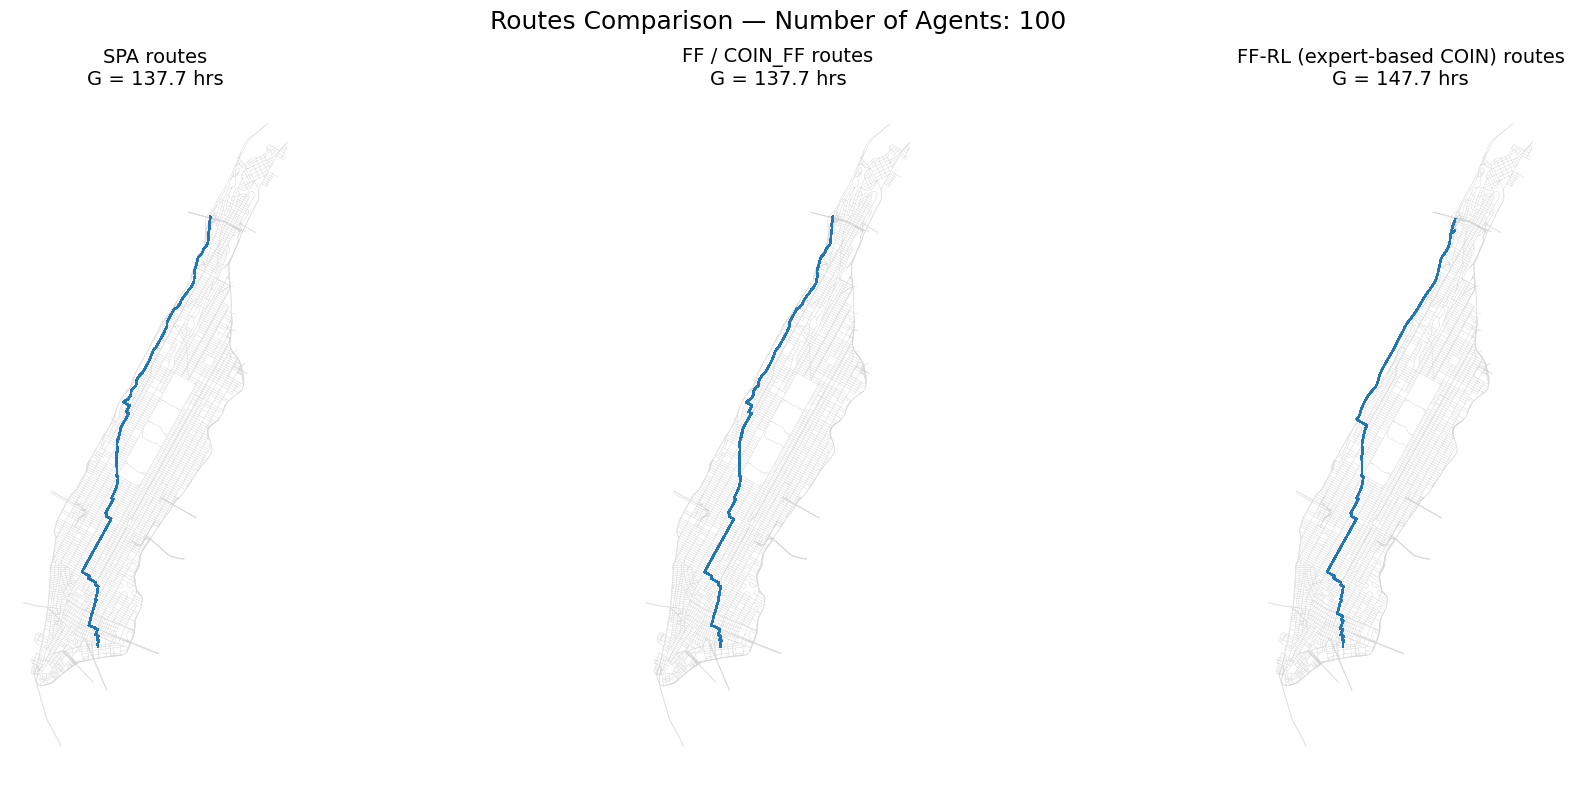

In [58]:
# Plots
plot_routes_three_way(
    gdf,
    agents_spa,      G_spa,
    agents_ff,  G_ff,
    agents_ff_rl, G_ff_rl,
    num_agents=num_agents,
)


### 16.2 Heatmap

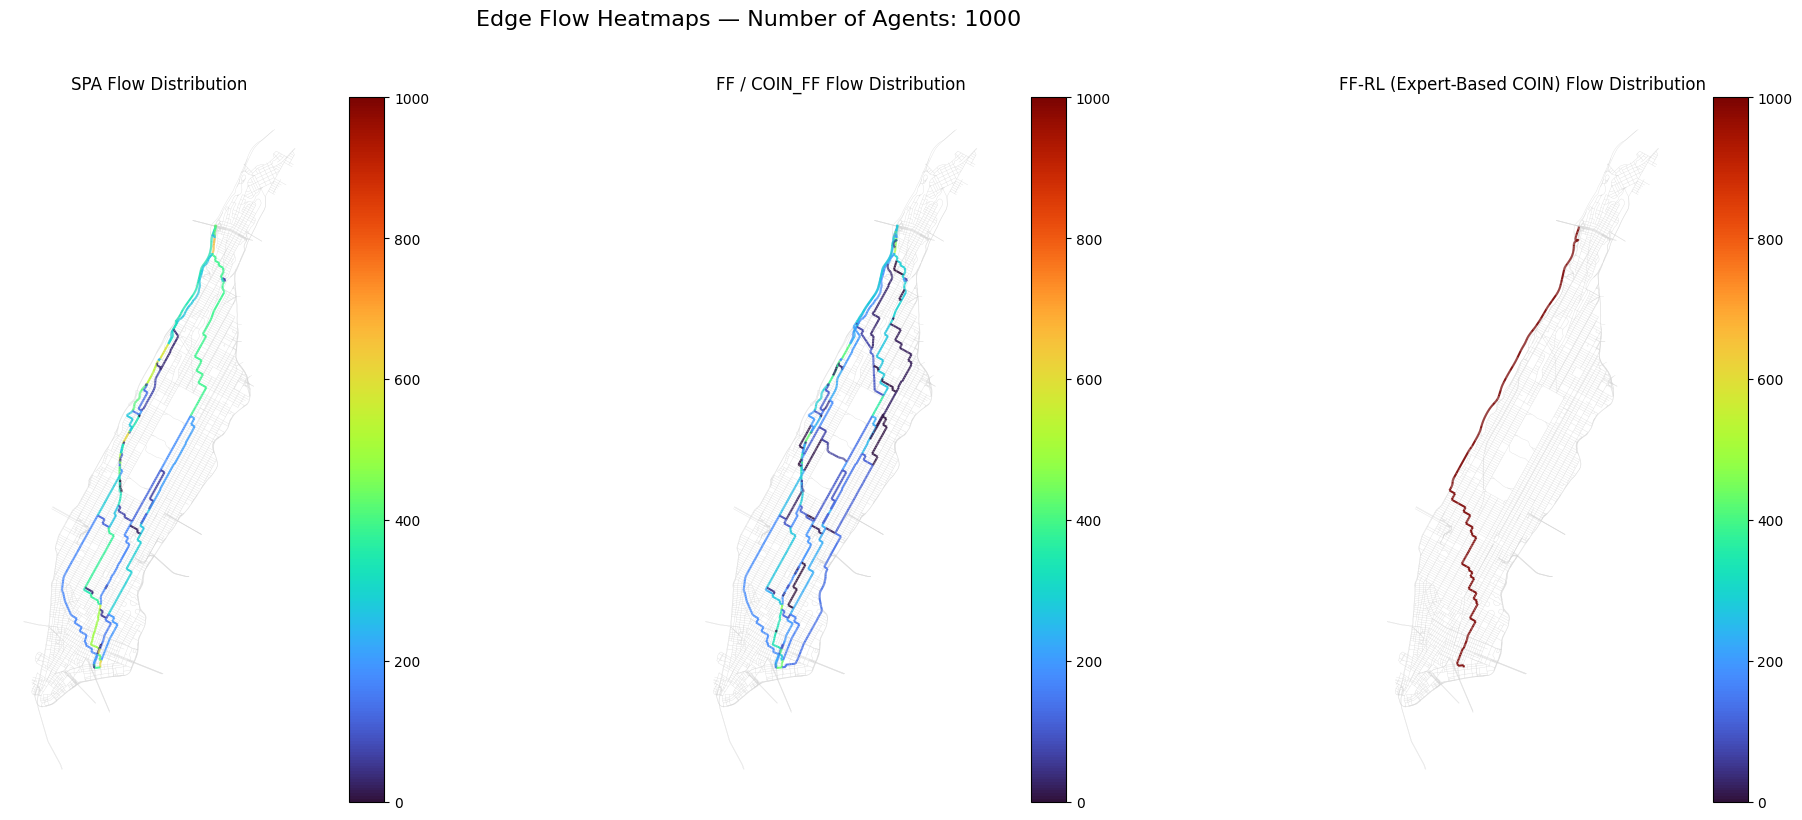

In [38]:
plot_heatmaps_three_way(
    gdf,
    manhattan_network,
    flows_spa,
    flows_ff,
    flows_ff_rl,
    num_agents=num_agents
)

## 17. Animation

In [36]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

def animate_routes_three_way_light(
    gdf: gpd.GeoDataFrame,
    agents_spa: list,
    agents_ff: list,
    agents_ff_rl: list,
    num_agents: int,
    out_path: str | None = None,
    max_frames: int = 80,      # total frames of the animation
    fps: int = 8,              # frames per second
    figsize=(10, 6),           # overall figure size
    dpi: int = 80,             # resolution
):
    """
    Lightweight 3-panel animation of SPA, FF/COIN_FF, and FF-RL (expert COIN) routes.

    Each panel:
      - draws the Manhattan network once as a gray background
      - shows the routes being constructed over time

    The function:
      - sub-samples each path so we only use `max_frames` frames
      - saves as an MP4 (much smaller than GIF)

    Parameters
    ----------
    gdf : GeoDataFrame
        Street network (same you used for static plots).
    agents_spa, agents_ff, agents_ff_rl : list[Agent]
        Agents with .path = [node0, node1, ...].
    num_agents : int
        Number of agents used in the experiment (for title + filename).
    out_path : str or None
        Output file name (MP4). If None, a name with num_agents is used.
    max_frames : int
        Maximum number of frames in the animation.
    fps : int
        Frames per second.
    figsize : tuple
        Matplotlib figure size.
    dpi : int
        Resolution of the saved video.
    """

    # auto-generate filename if not provided
    if out_path is None:
        out_path = f"routes_three_way_{num_agents}_agents.mp4"

    # --- helper: convert Node -> (x, y) ---
    def node_xy(node):
        x, y = node  # your Node is an (x, y) tuple
        return x, y

    # --- prepare figure with 3 subplots ---
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    titles = [
        "SPA routes",
        "FF / COIN_FF routes",
        "FF-RL (Expert COIN) routes",
    ]

    # draw background network once in each subplot
    for ax, title in zip(axes, titles):
        gdf.plot(ax=ax, color="lightgrey", linewidth=0.3)
        ax.set_axis_off()
        ax.set_title(title, fontsize=10)

    # global title with number of agents
    fig.suptitle(
        f"Animation for {num_agents} agents",
        fontsize=12,
        fontweight="bold",
        y=0.97
    )

    # for each scenario, convert paths to (xs, ys) lists
    scenarios_agents = [agents_spa, agents_ff, agents_ff_rl]
    scenarios_paths_xy = []     # per scenario: list of (xs, ys)
    global_max_len = 0          # longest path across all scenarios

    for agents in scenarios_agents:
        paths_xy = []
        for a in agents:
            if not getattr(a, "path", None) or len(a.path) < 2:
                continue
            xs, ys = zip(*[node_xy(n) for n in a.path])
            paths_xy.append((xs, ys))
            global_max_len = max(global_max_len, len(xs))
        scenarios_paths_xy.append(paths_xy)

    if global_max_len == 0:
        print("No non-empty paths to animate.")
        plt.close(fig)
        return

    # total frames = min(max_frames, longest path length)
    n_frames = min(max_frames, global_max_len)

    # for each scenario and each path, precompute indices per frame
    scenarios_indices_per_frame = []
    for paths_xy in scenarios_paths_xy:
        idx_lists = []
        for xs, ys in paths_xy:
            L = len(xs)
            if L <= 1:
                idx_lists.append([0] * n_frames)
                continue
            idxs = [
                min(int((k / (n_frames - 1)) * (L - 1)), L - 1)
                for k in range(n_frames)
            ]
            idx_lists.append(idxs)
        scenarios_indices_per_frame.append(idx_lists)

    # line objects for each path in each scenario
    scenarios_lines = []
    for ax, paths_xy in zip(axes, scenarios_paths_xy):
        scenario_lines = []
        for xs, ys in paths_xy:
            line, = ax.plot([], [], linewidth=1.5)
            scenario_lines.append(line)
        scenarios_lines.append(scenario_lines)

    # --- animation callbacks ---
    def init():
        for scenario_lines in scenarios_lines:
            for line in scenario_lines:
                line.set_data([], [])
        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    def update(frame):
        for paths_xy, idx_lists, lines in zip(
            scenarios_paths_xy,
            scenarios_indices_per_frame,
            scenarios_lines
        ):
            for (xs, ys), idxs, line in zip(paths_xy, idx_lists, lines):
                idx = idxs[frame]
                line.set_data(xs[:idx + 1], ys[:idx + 1])

        return [line for scenario_lines in scenarios_lines for line in scenario_lines]

    anim = FuncAnimation(
        fig,
        update,
        frames=n_frames,
        init_func=init,
        blit=True,
        interval=1000 // fps,
    )

    # save as MP4 (small-ish)
    writer = FFMpegWriter(fps=fps, bitrate=1200)  # tweak bitrate if you want smaller file
    anim.save(out_path, writer=writer, dpi=dpi)
    plt.close(fig)

    print(
        f"Saved 3-way route animation to {out_path} "
        f"({n_frames} frames, {fps} fps, {num_agents} agents)"
    )

In [ ]:
animate_routes_three_way_light(
    gdf,
    agents_spa,
    agents_ff,
    agents_ff_rl,
    num_agents=num_agents,
    out_path=None,        # or leave out to auto-name with num_agents
    max_frames=80,
    fps=8,
)